# Process ch 5-8 with changing watertank shift
here I will process channel 5-8 with the changing watertank shift.
So the watertank value measurement time will fit to the DTS measurement time.
This will give some data gaps, because the Watertank temperature is not always avaible.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file
import math
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft

%load_ext autoreload
%autoreload 2
from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, calc_diff_between_channels, watertank_shift, read_pickle, write_pickle, temp_watertank_func, random_date, check_first_last_date, cut_dataframe_to_range_tlogger, check_processed_data, calc_mean_for_each_segment, plot_segments_mean_correction, const_shift_data, add_nan_val_in_datagaps, carpet_plot_with_gaps,save_values_in_file
from my_func_mvw.fourier_transform_func import resample_data_func, plot_frequency_spectrum, fourier_transform

plot_save=True #True False
show_large_plot=False #True False
calc_shiftfirst=False #logical wrong way to average the data

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

Some Version information of the imported packages
pandas version: 1.3.2
pickle version: 4.0


In [2]:
# Was sind diese Daten genau? Verstehe Einheit glaube ich nicht
# dämpfungen = pd.read_csv("alle_Messungen_DAEMPFUNG.txt",sep="\t",index_col=0,header=0)

# dämpfungen
# dämpfungen.info()
# dämpfungen hat weniger reihen als tmep, also weniger Längen
# und weniger Spalten also Daten, am Ende fehlen welche

#temp = pd.read_csv("alle Messungen_TEMP.txt",sep="\t",index_col=0,header=0)

In [3]:
#Load data
path_to_my_database = r"..\Alsdorf\Daten\my_database"
# data_2019 = import_my_database_csv(2019, path_to_my_database + r"\csv")
# data_2020 = import_my_database_csv(2020, path_to_my_database + r"\csv")
# data_2021 = import_my_database_csv(2021, path_to_my_database + r"\csv")

# Load pickle Data
data_all = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_all")

# delete other cable channels
for old_chan in ["1","2","3","4"]:
    del data_all[old_chan]

In [4]:
if show_large_plot:     
    carpet_plot_with_gaps(data_all,["5","6","7","8"],title_prefix="Raw Temperature ",sample_hours=3,vmin=22,vmax=26)
    if plot_save:
        plt.savefig(r"pictures\raw_data_ch58_carpet.png")
        plt.savefig(r"..\Masterthesis_tex\appendix\raw_data_ch58_carpet.pdf", format="pdf",bbox_inches="tight")
    plt.show()

In [5]:
# divide into segments of the same kalibration (QuickStart)
# "22-07-2021 13:30:29" angepasst, sodass es besser zu Daten passt
# "14-07-2021 14:16:59" angepasst, sodass es besser zu Daten passt
# letzten hinzugefügt
# divide into segments of the same kalibration (QuickStart)
# ich glaube nicht das an jedem von diesem Datums der Quickstart neu gemacht wurde
string=["2020-12-09 11:02:45", "2021-04-07 12:43:35", "2021-04-26 10:57:11",
    "2021-04-28 09:41:06", "2021-05-20 16:02:01", "2021-06-01 15:06:12","14-07-2021 14:16:59","22-07-2021 13:30:29"]
string=["2021-06-01 15:06:12", "14-07-2021 12:58:00", "22-07-2021 11:50:00", "2021-08-02 11:08:00"] #adapted for ch 5-8

dates=[pd.to_datetime(s) for s in string] #also used later for plotting
first_date=data_all["5"].index[0]
last_date=data_all["8"].index[-1]

calibration_segments = []
first_segment=[first_date, dates[1]] # first_date entspricht bei diesen channeln ca. erstem QuickStart
last_segment=[dates[-1],last_date]

calibration_segments.append(first_segment)
for i in range(1,len(dates[1:])): #skip first one, because its already first_segment
    segment = [dates[i], dates[i+1]]
    calibration_segments.append(segment)
calibration_segments.append(last_segment)

## Raw data

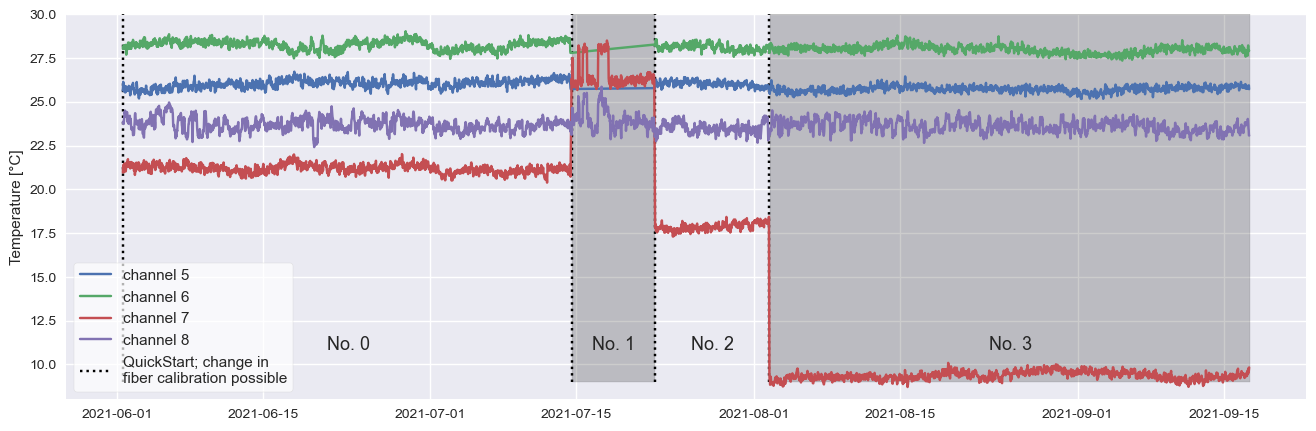

In [6]:
fig,axs=plt.subplots(1,1,figsize=(16,5))
length=800

axs.vlines(dates,9,30,colors="black",linestyle=":",label="QuickStart; change in\nfiber calibration possible")

for chan in ["5","6","7","8"]:
    axs.plot(data_all[chan][length],label=f"channel {chan}")

# Correction Segments
def color_cable_pos_calb_seg(calibration_segment, alph, ymax=30, ymin=9, col="black", label_name="none", label=False, axs=axs):
    """ creates patches which color the plot
    I slightly adapt this for every notebook
    """
    start_len = datetime.fromtimestamp(calibration_segment[0].timestamp())
    end_len = datetime.fromtimestamp(calibration_segment[1].timestamp())
    width = end_len - start_len
    start_len_num=mdates.date2num(start_len)
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax-ymin,color=col,alpha=alph)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
        date_num=mdates.date2num(start_len+width/2)
        axs.text(date_num,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=13,bbox=bbox_props)

alph=0.0
counter=0
for segment in calibration_segments:
    color_cable_pos_calb_seg(segment,alph,axs=axs,label_name=f"No. {counter}",label=True)
    if alph == 0.0:
        alph+=0.2
    elif alph == 0.2:
        alph=0.0
    counter+=1

#axs.set_title(f"Uncorrected data, Length: {length}", fontsize=13)
#axs.set_xlabel("Date")
axs.set_ylabel("Temperature [°C]")
axs.set_ylim([8,30]) #8, 30
legend = plt.legend(fontsize=11, title_fontsize=11,frameon=True)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7) #not supported with eps

# Save additional information so I can read them in my tex file
save_values_in_file(0,"cable_length_plot_raw_data_ch58",length,r"..\Masterthesis_tex\values_for_read_in_tex.txt")

if plot_save:
    plt.savefig(r"pictures\raw_data_ch58.png")
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\raw_data_ch58.pdf", format="pdf",bbox_inches="tight")
plt.show()

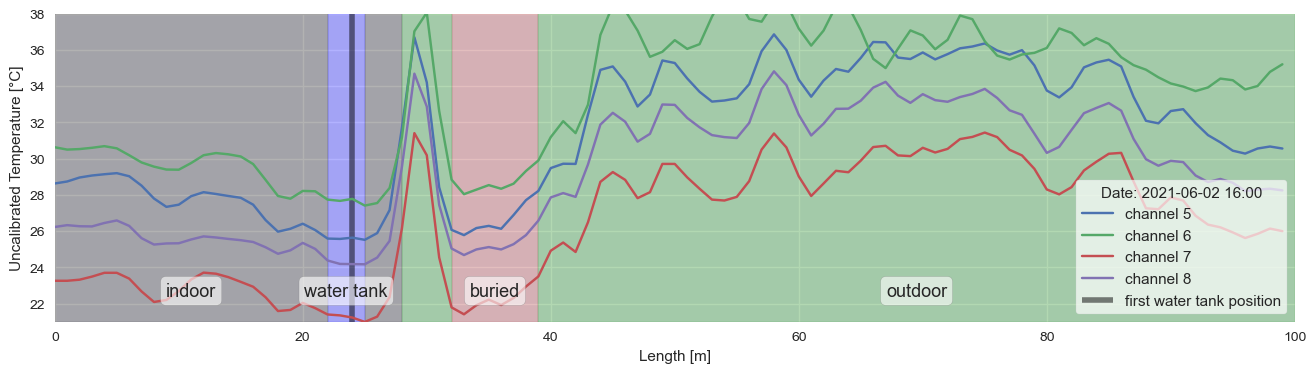

In [7]:
def color_cable_pos(start_len, end_len, alph, axs, ymax=30, ymin=20, col="black", label_name="none", label=False):
    """ creates patches which color the plot
    I slightly adapt this for every notebook
    """
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax-ymin,color=col,alpha=alph)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.6)
        axs.text(start_len+width/2,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=13,bbox=bbox_props)

iloc_date_index=50
ymin=21;ymax=38
fig,axs=plt.subplots(1,1,figsize=(16,4))
for chan in ["5","6","7","8"]:
    data_chan=data_all[chan].iloc[iloc_date_index][:100]
    axs.plot(data_chan,label=f"channel {chan}")

date_name=str(data_all["6"].iloc[iloc_date_index].name.round("1h"))[:-3]
axs.set_ylabel("Uncalibrated Temperature [°C]")
axs.set_xlabel("Length [m]")
axs.set_xlim(0,100)
axs.set_ylim(ymin,ymax)
axs.vlines([24],ymin,ymax,label="first water tank position",color="black",linewidth=4,alpha=0.5)

color_cable_pos(0,22,0.3,ymax=ymax,ymin=ymin,axs=axs, label_name="indoor", label=True)
color_cable_pos(22,25,0.3,ymax=ymax,ymin=ymin,axs=axs,col="blue", label_name="water tank", label=True)
color_cable_pos(25,28,0.3,ymax=ymax,ymin=ymin,axs=axs,col="black")
color_cable_pos(28,32,0.3,ymax=ymax,ymin=ymin,axs=axs,col="green", label_name="outdoor", label=False)
color_cable_pos(32,39,0.3,ymax=ymax,ymin=ymin,axs=axs,col="brown", label_name="buried", label=True)
color_cable_pos(39,100,0.3,ymax=ymax,ymin=ymin,axs=axs,col="green", label_name="outdoor", label=True)

legend = axs.legend(fontsize=11, title_fontsize=11,frameon=True,title=f"Date: {date_name}",loc="lower right")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7)

if plot_save:
    plt.savefig(r"..\Masterthesis_tex\appendix\watertank_loc_raw_ch58.pdf", format="pdf",bbox_inches="tight")
    plt.savefig("pictures\watertank_loc_raw_ch58.png")
plt.show()


In [8]:
# import tlogger
# read csv
# Tlogger_PT1000 = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000.csv", index_col=[0])
# Tlogger_PT100  = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated.csv",index_col=[0])
# Tlogger_PT100.index.names=["Date"]; Tlogger_PT1000.index.names=["Date"]
# Tlogger_PT100.index = pd.to_datetime(Tlogger_PT100.index); Tlogger_PT1000.index = pd.to_datetime(Tlogger_PT1000.index)

#read_pickle
df_Tlogger_PT1000 = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000")
df_Tlogger_PT100  = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated")

watertank_T_range_min = df_Tlogger_PT100.index.min()
watertank_T_range_max = df_Tlogger_PT100.index.max()

df_Tlogger_PT100

,Channel1-Watertank_PT100,Channel2-Air,Channel1-PT100_rolling_mean
2021-06-07 12:12:40,23.4,25.8,23.5
2021-06-07 12:13:40,23.5,25.4,23.5
2021-06-07 12:14:40,23.4,25.2,23.5
2021-06-07 12:15:40,23.5,24.9,23.5
2021-06-07 12:16:40,23.5,24.8,23.5
...,...,...,...
2021-09-17 12:04:53,20.3,NaN,20.3
2021-09-17 12:07:53,20.3,NaN,20.3
2021-09-17 12:10:54,20.3,NaN,20.3
2021-09-17 12:13:54,20.3,NaN,20.3


## Alligning

In [9]:
data_all_processed=deepcopy(data_all)

# remove unrealistiv values of corrected data - relativ großzügig
# channel 5, 6 825 bis 900 a lot of noise in channel 6
a=data_all_processed #for shortening code
for chan in ["5","6"]:
    for length in range(850,870,1): # from 850 to 869 (both inclusive) delete all values
        a[chan][length] = np.nan

for chan in ["7","8"]:
    for length in range(1700,1716,1): # from 1700 to 1715 (both inclusive) delete all values
        a[chan][length] = np.nan

# drop last value, because chan5 is "longer" than chan6; determined by test measurement of DTS device
a["5"] = a["5"].drop(1708,axis=1)

# adapt dataframes so that during avearaging (flipping dataframe columns), the watertank positions are avearaged
##################eventually adapt if changing watertank position##########################
# both dataframes have a length of 1708 now (max value length 1707)
#1707-25=1682 # 25 position from the back --> 1689 of one channel is not avearaged with 25 of other channel
a["5"] = a["5"].drop([0,1,2,3,4,5,6],axis=1)
a["6"] = a["6"].drop([0,1,2,3,4,5,6],axis=1)
# 25 is now index 19 (position 20) and 1689 is index -20; index 0 is avearaged with -1 and so on

# ### test - bringt keine Verbesserung, habe 1600 und 100 auch getauscht
# # ich muss es dann reindexen, da die column names dann nicht mehr passen
# # move channel 6 to the left, at position 300 and onward
# a["5"] = a["5"].drop([1600],axis=1) # Wassertank position wird mit verschoben!!!!!!!!!!!!!
# a["6"] = a["6"].drop([100],axis=1) #remove one which is before the watertank
# # reset index so its the same for channel 5 and 6 again
# a["5"].reset_index()
# a["6"].reset_index()
# ###

a["7"] = a["7"].drop([0,1,2,3,4,5],axis=1)
a["8"] = a["8"].drop([0,1,2,3,4,5],axis=1)
# 25 is now index 19 (position 20) and 3389 is index -20; index 0 is avearaged with -1 and so on
a["7"] = a["7"].drop([1800,1801],axis=1)
a["8"] = a["8"].drop([1800,1801],axis=1)
# 1689 is now index 1683 and 1723 is index -1684
#################################################################################

###################### Correct date missmatch, must be done manually at the moment####################################
# print("--- Before removing date points ---")
# check_first_last_date(a)
# print("--- --- --- --- --- --- --- --- --- ---")
a["5"] = a["5"].drop(a["5"].index[1929],axis=0) # Measurement stop
a["5"] = a["5"].drop(a["5"].index[0],axis=0)
a["6"] = a["6"].drop(a["6"].index[0:1],axis=0)
a["7"] = a["7"].drop(a["7"].index[0:1],axis=0)
a["8"] = a["8"].drop(a["8"].index[0:1],axis=0)

# Check if the changes are as expected
#print("--- After removing some date points ---")
#check_first_last_date(a) # done in next cell anyway
####################################################################################################################

In [10]:
ilocs=[2402,2403,2404,2405,2406,2897] 
#2402: 2021-07-22 10:45:05; 2897: "2021-08-02 11:08:22"
# drop/delete dates which cant be corrected with good results
# drop/delete them also in channel 8 so the data is alligned
print("variable: data_all_processed")
for chan in ["7","8"]:
    dat=data_all_processed[chan]
    for iloc in ilocs:
        dat.iloc[iloc] = np.nan
        print(f"deleted {dat.iloc[iloc].name} in channel {chan}")


# maybe I should delete at every border some values. Because the device needs some time to warm up?

variable: data_all_processed
deleted 2021-07-22 10:45:05 in channel 7
deleted 2021-07-22 11:09:06 in channel 7
deleted 2021-07-22 11:58:50 in channel 7
deleted 2021-07-22 12:30:52 in channel 7
deleted 2021-07-22 13:02:53 in channel 7
deleted 2021-08-02 11:06:22 in channel 7
deleted 2021-07-22 10:49:05 in channel 8
deleted 2021-07-22 11:13:06 in channel 8
deleted 2021-07-22 12:02:51 in channel 8
deleted 2021-07-22 12:34:52 in channel 8
deleted 2021-07-22 13:06:53 in channel 8
deleted 2021-08-02 11:10:22 in channel 8


In [11]:
data_all_processed_withoutTlogger = deepcopy(data_all_processed) # used for const shift correction

# Check my processed data
my_Warning = check_processed_data(channels=["5","6","7","8"], data_all_processed = data_all_processed_withoutTlogger, gap_end=2404, gap_begin=1928)
# gap_begin=1928
# gap_end=2404
# # gap_begin=1661
# # gap_end=2137

Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


In [12]:
# Cut dataframes so they only cover the time of the t-Logger
# only cuts start and end does not account for datagaps in tlogger!

#do seperate due to data gaps, therefore iloc of the dates is not corresponding to same date_name
data_all_processed_56 = cut_dataframe_to_range_tlogger(channels=["5","6"],data = data_all_processed,do_check=False, 
    watertank_T_range_min = watertank_T_range_min, watertank_T_range_max = watertank_T_range_max)
data_all_processed_78 = cut_dataframe_to_range_tlogger(channels=["7","8"],data = data_all_processed,do_check=False,
    watertank_T_range_min = watertank_T_range_min, watertank_T_range_max = watertank_T_range_max)
data_all_processed["5"] = data_all_processed_56["5"]
data_all_processed["6"] = data_all_processed_56["6"]
data_all_processed["7"] = data_all_processed_78["7"]
data_all_processed["8"] = data_all_processed_78["8"]
del data_all_processed_78; del data_all_processed_56

In [13]:
# Add Manual correction here##################################
data_all_processed["7"] = data_all_processed["7"].drop(data_all_processed["7"].index[0],axis=0)
data_all_processed["8"] = data_all_processed["8"].drop(data_all_processed["8"].index[0],axis=0)
# für übergangslösung !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
data_all_processed["7"] = data_all_processed["7"].drop(data_all_processed["7"].index[-1],axis=0)
data_all_processed["8"] = data_all_processed["8"].drop(data_all_processed["8"].index[-1],axis=0)
##########
a=data_all_processed
a["5"] = a["5"].drop(a["5"].index[-1],axis=0)
a["6"] = a["6"].drop(a["6"].index[-1],axis=0)
############################################
# check_first_last_date(data_all_processed) done in next cell anyway

In [14]:
# Check my processed data
my_Warning = check_processed_data(channels=["5","6","7","8"], data_all_processed = data_all_processed, gap_begin=1661, gap_end=2137)
# gap_begin=1928
# gap_end=2404
# # gap_begin=1661
# # gap_end=2137

Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


## Calculate offset and  Shift

In [15]:
#70 s
#24 1689 1723 3389
watertank_len=[24,1689,1723,3389] # position DTS cable, where it is in watertank; vorher [19,1690,1723,3389] [25,1690,1723,3389]
# keep in mind the dataframe starts not at 0. watertank_len contains the real distances, so dont use .columns[watertank_len[x]]
# Wie habe ich aktuell die Wassertank positionen bestimmt: 
# watertank angeguckt und die position finden wo starke änderrungen sind über die Zeit sin --> draußen
# Zwei bis drei Längeneinheiten richtung DTS Gerät gegangen, dort sind dann keine starken Änderrungen über die Zeit 
    # --> Wassertankposition
# Dann die Dataframes von den Channeln die ich mittele so bearbeiten, dass genau die Wassertank positionen gemittelt werden
    # ein parr Längen /Spalten entfernt
# Positionen sind nicht ganz richtig, oder Längen die vom DTS Kabel generiert wurden stimmen nicht

# Correction for waterteank temp difference
data_all_processed_shifted, watertank_diff_log_data_all = watertank_shift(data_all_processed, df_Tlogger_PT100, watertank_len=watertank_len,watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)

# Calculate mean of channels

In [16]:
def avearge_two_channels(chanx,chany):
    """one channel (chanx) is flipped (length). After that the mean of all values is calculated.
    Only use this for processed data
    """
    # Calculate new index
    # calculate mean of both indexes and check the time difference; checking the time difference is not needed anymore
    #because its already done data processing check. But I think it does not take much computing power, so I left it here
    time_diff_allowed = 5 # in minutes
    new_index=[]
    for i in range(len(chanx)):
        ts1=chanx.index[i] # ts: timestamp
        ts2=chany.index[i]
        # calculate mean time of both channels, it will be used as index for the result.
        if ts1 > ts2:
            tsmean=ts1-(ts1-ts2)/2
            if ts1-ts2 > timedelta(minutes=time_diff_allowed): 
                print(f"Warning 1: Large time difference between both channels: {ts1-ts2} at index {i}")
        elif ts1 < ts2:
            tsmean=ts2-(ts2-ts1)/2
            if -(ts1-ts2) > timedelta(minutes=time_diff_allowed):
                print(f"Warning 2: Large time difference between both channels: {-(ts1-ts2)} at index {i}")
        else:
            print("Warning 3: Timestamps equal. Not expected")
        new_index.append(tsmean.round(freq="S"))
    new_index=pd.Series(new_index,name="Date") # to series so it can be used in .set_index

    # change index, so they are equal
    chany = chany.set_index(new_index)
    chanx = chanx.set_index(new_index)
    # flip dataframe one channel (channel 5)
    # Two possibilities
    # 1. Flip data of dataframe
    # chanx = chanx[chanx.columns[::-1]] # flip the whole dataframe: columns and data
    # chanx.columns = chanx.columns[::-1] # datframes are added based on column names, so I need to change them in one dataframe
    # 2. flip only columns (rename them), because by adding two dataframes the values with the same column name are added
    chanx_flipped = deepcopy(chanx) # otherwise I will flip the chanx dataframe for the rest of the notebook
    chanx_flipped.columns = chanx_flipped.columns[::-1]
    # calculate mean of Temperature values
    chanxy_mean = (chanx_flipped + chany)/2

    return chanxy_mean # column names original from chany

# Create mean of channels
if calc_shiftfirst:
    chan_mean_shiftfirst={}
    chan_mean_shiftfirst["5and6"] = avearge_two_channels(data_all_processed_shifted["5"], data_all_processed_shifted["6"])
    chan_mean_shiftfirst["7and8"] = avearge_two_channels(data_all_processed_shifted["7"], data_all_processed_shifted["8"])
    # columns (length) corresponds to second channel, channel 6 and channel 8

# Avearge first and make the watertank correction after that
**Idee:** Ich könnte auch beide Channel vor dem aveargen auf das gleiche Nivau bringen, also Differenz der Mittelwerte nehmen und beide Kurven so verschieben, dass sie den gleichen Mittelwert haben. Dann Mitteln und danach auf Wassertank position verschieben.

In [17]:
#40s
chan_mean_avearagefirst_not_shifted={}
chan_mean_avearagefirst_not_shifted["5and6"]=avearge_two_channels(data_all_processed["5"], data_all_processed["6"])
chan_mean_avearagefirst_not_shifted["7and8"]=avearge_two_channels(data_all_processed["7"], data_all_processed["8"])

chan_mean_avearagefirst={}
# auf Wassertank verschieben bei watertank_len[0] m
chan_mean_avearagefirst, watertank_diff_log_avearagefirst = watertank_shift(chan_mean_avearagefirst_not_shifted, df_Tlogger_PT100, channels=["5and6","7and8"],  watertank_len=watertank_len, watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)

# Save processed data

In [18]:
write_pickle(path_to_my_database + "\..\my_database_additional_local\chan_mean_avearagefirst",chan_mean_avearagefirst)
write_pickle(path_to_my_database + "\..\my_database_additional_local\watertank_diff_log_data_all",watertank_diff_log_data_all)
write_pickle(path_to_my_database + "\..\my_database_additional_local\data_all_processed",data_all_processed)
write_pickle(path_to_my_database + "\..\my_database_additional_local\data_all_processed_shifted",data_all_processed_shifted)
write_pickle(path_to_my_database + "\..\my_database_additional_local\watertank_diff_log_avearagefirst",watertank_diff_log_avearagefirst)
if calc_shiftfirst:
    write_pickle(path_to_my_database + "\..\my_database_additional_local\chan_mean_shiftfirst",chan_mean_shiftfirst)


# Process ch 5-8 with mean watertank shift
here I will process channel 5-8 with the mean watertank shift.
Therefore I will divide the data in different "QuickStart" sets.

#### Plot: Is correction time dependent?

In [19]:
calibration_segments_mean_correction, calibration_segments_mean_correction_dates = calc_mean_for_each_segment(
    ["5","6","7","8"], calibration_segments, watertank_diff_log_data_all, watertank_len)
# calibration_segments_mean_correction = result[0]
# calibration_segments_mean_correction_dates = result[1]
# del result

c:\Users\Mathis\Desktop\Masterthesis\Scripts_Masterarbeit\my_func_mvw\functions.py:387: RuntimeWarning: Mean of empty slice
  segment_mean = np.nanmean(data[date_iloc_start+5:date_iloc_end-5])


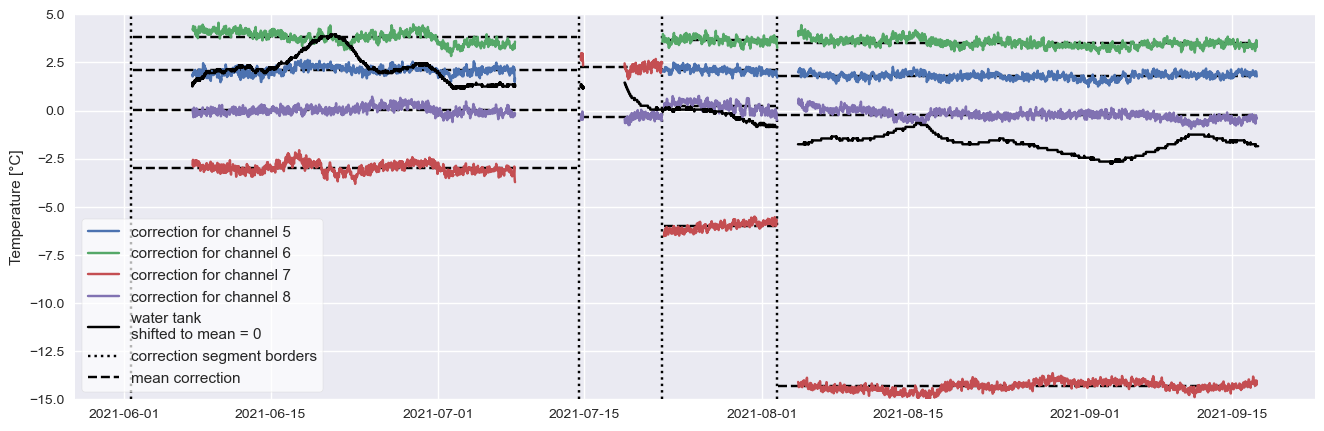

In [20]:
plot_segments_mean_correction(calibration_segments_mean_correction,dates,calibration_segments_mean_correction_dates,watertank_diff_log_data_all,df_Tlogger_PT100,watertank_len,ymax=5, ymin=-15)

if plot_save:
    plt.savefig(r"pictures\analyse_watertank_correction_58.png")
    plt.savefig(r"..\Masterthesis_tex\figs\chap3\analyse_watertank_correction_ch58.pdf", format="pdf",bbox_inches="tight")

plt.show()

# Manually correct EGRT segment channel 8, sould fit better to other data

# Correct data with const shift for each segment
Advantage: no datagaps (only the ones I want to have at segment borders)
at the moment the shift is determined with the data of the atertank correction for each sgement.

But especially for the older data of chan 1 - 4 I want to determine it from the raw data. This should be also usefull for the EGRT segment due to the large data gaps.

In [21]:
data_all_processed_constshifted = const_shift_data(["5","6","7","8"],calibration_segments, 
                                                   calibration_segments_mean_correction,data_all_processed_withoutTlogger,round_x=1)

my_Warning = check_processed_data(channels=["5","6","7","8"], data_all_processed = data_all_processed_constshifted, 
                                  gap_begin=1928, gap_end=2404)

Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


In [22]:
# sollten das resamplete nochmal überprüfen!!!!!!!!!!!!!!!
# Used later in plot
resampled_data={}
sample_hours=1 #need to play around with it until all chanells have same index length after resample
for chan in ["5","6","7","8"]:
    # skip first row so all dataframes start at 14:xx:xx --> resampled to same dates
    #skip last so all end at same hour; NEEDS TO BE ADAPTED WITH NEW DATA
    data_with_nan = add_nan_val_in_datagaps(data_all_processed_constshifted[chan][1:-1], minutes_gap=35)
    resampled_data[chan]=data_with_nan.resample(f"{sample_hours}H").ffill()

print("Index Length:")
for chan in ["5","6","7","8"]:
    print(f"{chan}: {len(resampled_data[chan].index)}")
    print(f"first date: {resampled_data[chan].index[0]}; last date: first date: {resampled_data[chan].index[-1]}")
    
# original data
#print("Index Length:")
#for chan in ["5","6","7","8"]:
#    print(f"{chan}: {len(data_all_processed_constshifted[chan].index)}")
#    print(f"first date: {data_all_processed_constshifted[chan].index[1]};
#          last date: first date: {data_all_processed_constshifted[chan].index[-1]}")

# shorten columns so all dataframes have equal column names
for chan in ["7","8"]:
    col = resampled_data[chan].columns[1:1702]
    resampled_data[chan] = resampled_data[chan][col]

331 dates with nan have been added
331 dates with nan have been added
5 dates with nan have been added
5 dates with nan have been added
Index Length:
5: 2588
first date: 2021-06-01 14:00:00; last date: first date: 2021-09-17 09:00:00
6: 2588
first date: 2021-06-01 14:00:00; last date: first date: 2021-09-17 09:00:00
7: 2588
first date: 2021-06-01 14:00:00; last date: first date: 2021-09-17 09:00:00
8: 2588
first date: 2021-06-01 14:00:00; last date: first date: 2021-09-17 09:00:00


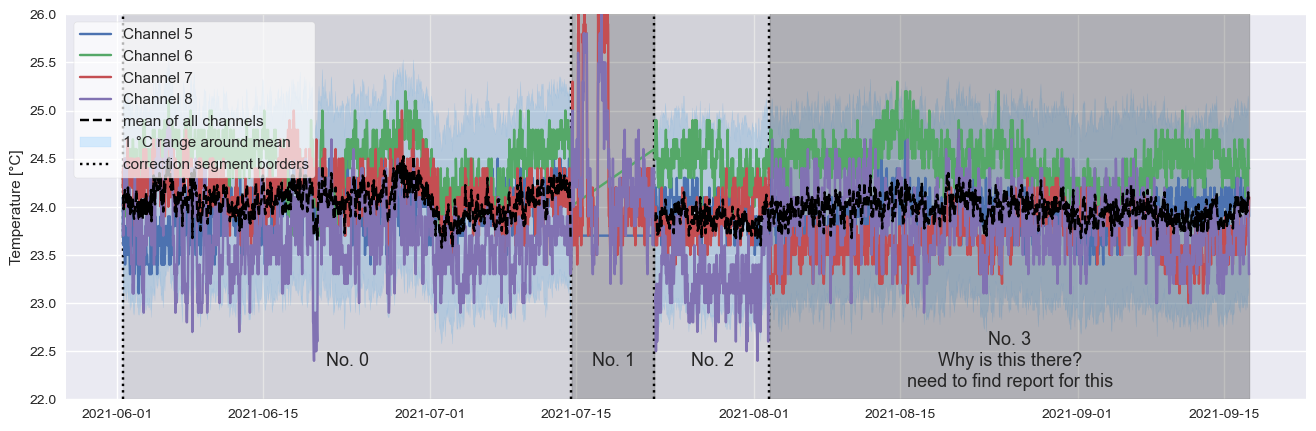

In [23]:
# Erste axis mit tlogger weglassen?
# in alle Axen min max von allen channeln als hintergund plotten zur orientierung?
# eigentlich brauche ich für meine thesis nur die letzte axis würde ich sagen

cable_length=800 #watertank_len=[25,1689,1723,3389]
fig,axs=plt.subplots(1,1,figsize=(16,5))

# other axes
ymin=22; ymax=26
for chan in ["5","6","7","8"]:
    #axs.plot(data_all_processed_shifted[chan][800], label=f"variable shift, channel {chan},")#, color="blue")
    axs.plot(data_all_processed_constshifted[chan][cable_length],label=f"Channel {chan}")#, color="green")

# mean off all channels
summe=0
# to avoid datagaps when a nan occurs; I think I need calculate this date wise.
for chan in ["5","6","7","8"]:
    summe += resampled_data[chan][cable_length]
mean=summe/4 #nan values should cause nan in mean too
axs.plot(mean,label=f"mean of all channels",color="black", linestyle="--")
axs.fill_between(mean.index,mean.values-1, mean.values+1,
                 #facecolor="blue", # The fill color
                 color='#7fc7ff',       # The outline color
                 alpha=0.3, label = "1 °C range around mean")          # Transparency of the fill

axs.vlines(dates,ymin,ymax,colors="black",linestyle=":", label="correction segment borders")    

axs.set_ylim(ymin,ymax)
axs.legend()
axs.set_ylabel("Temperature [°C]")
#axs.set_xlabel("Date")
color_cable_pos_calb_seg(calibration_segments[0],0.1, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 0", label=True)
color_cable_pos_calb_seg(calibration_segments[1],0.25, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 1", label=True)
color_cable_pos_calb_seg(calibration_segments[2],0.1, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 2", label=True)
color_cable_pos_calb_seg(calibration_segments[3],0.25, ymax=ymax, ymin=ymin,axs=axs,
                label_name="No. 3\nWhy is this there?\nneed to find report for this", label=True)
legend = axs.legend(fontsize=11, title_fontsize=12,frameon=True,loc="upper left")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7) #not supported with eps

# Save additional information so I can read them in my tex file
save_values_in_file(3,"cable_length_plot_final_data_ch58_one_length",cable_length,r"..\Masterthesis_tex\values_for_read_in_tex.txt")

if plot_save:
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\final_data_ch58_one_length.pdf", format="pdf",bbox_inches="tight")
plt.show()
# wenn ich beim letzten Segment mehr Daten habe passt es evntl besser? Oder ich muss erstes Segment noch um 0.1 mehr verschieben?
# Vergleich zwischen channel 7 und 8 für zweites segment sehr komische
# es könnte auch sein, dass channel 8 bemessen wurde als die Heizphase gerade aus gemacht wurde
# Für diesen Test sind kurze Messzeiten auf Kosten der Genauigkeit besser, da sich Temperatur ja schnell ändert
# erklärt es aber eigentlich nicht wirklich, müsste dann trotzdem viel ähnlicher sein
# es sieht so aus als ob channel 8 in segment 2 noch Manuel etwas nach unten verschoben werden sollte
# letztes Segment in channel 7 manuel nach oben verschieben?

In [24]:
if show_large_plot:     
    carpet_plot_with_gaps(data_all_processed_constshifted,["5","6","7","8"],title_prefix="Final Temperature ",sample_hours=3,
                         vmin=22,vmax=26)
    if plot_save:
        plt.savefig(r"pictures\final_data_ch58_carpet.png")
        plt.savefig(r"..\Masterthesis_tex\appendix\final_data_ch58_carpet.pdf", format="pdf",bbox_inches="tight")
    plt.show()

## Intepretation
* PT100 manually corrected auf Solexperts Sensor: -1.5
* Im Segment von Solexperts Sensor sind auch ein paar Datenpunkte die PT100 manually corrected sind
* PT1000 sind die aktuellen Wassertank Messungen mit den neu installierten und kalibrierten Sensoren
* zweites PT100 manually corrected Segment bei channel 7 ist auch in Rohdaten ein const Steigung der Temp zu sehen
* Solexperts Sensor segment channel 8 manuell noch etwas nach unten verschieben, damit Daten konsistenter sind?
  * bei 25 ist der Sprung nicht so deutlich zu sehen

--> Norbert fragen in wie weit ich Daten verschieben soll, sodass sie in sich konsistent sind

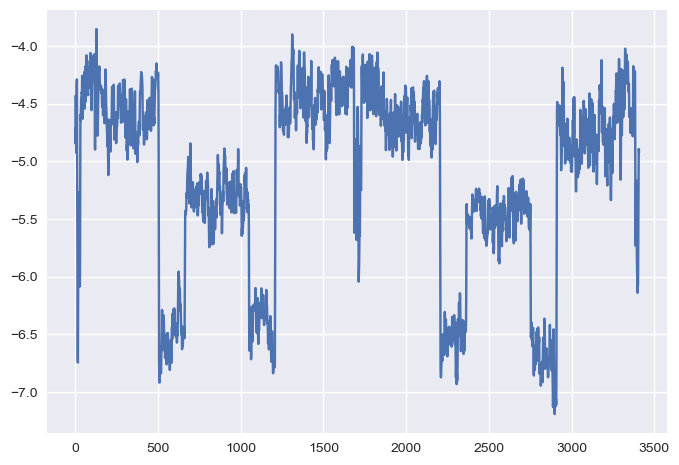

In [25]:
# Vergleichplot
# über große Zeiten ändert sich die Temperatur relativ stark
# Im Schacht aber eher nicht
# man muss drauf achten, dass beide Seiten gleich viel Tag und Nacht haben und gleiches Wetter
x=42 # how many dates to use for mean; one channel makes about 42 measurements in 24 hours
segment_border=1929 #1929, position of segment border; change it to a non-segment border for comparisson to that this method is not good
mean = data_all["7"].iloc[segment_border-x:segment_border].mean(axis=0) - data_all["7"].iloc[segment_border:segment_border+x].mean(axis=0)
plt.plot(mean)
plt.show()
# Sehr interressant könnte ich Norbert zeigen

## Aveargae Channels from constshift data

In [26]:
# Create mean of channels
if calc_shiftfirst:
    mean_constshift = {}
    mean_constshift["5and6"] = avearge_two_channels(data_all_processed_constshifted["5"], data_all_processed_constshifted["6"])
    mean_constshift["7and8"] = avearge_two_channels(data_all_processed_constshifted["7"], data_all_processed_constshifted["8"])
    # warning see check above when shifting the data

    mean_constshift["7and8"] = round(mean_constshift["7and8"],1)
    mean_constshift["5and6"] = round(mean_constshift["5and6"],1)

In [27]:
# Save const shift
write_pickle(path_to_my_database + "\..\my_database_additional_local\data_ch5-8_processed_constshifted",data_all_processed_constshifted)
write_pickle(path_to_my_database + "\data_ch5-8_processed_constshifted",data_all_processed_constshifted)
if calc_shiftfirst:
    write_pickle(path_to_my_database + "\..\my_database_additional_local\mean_ch5-8_constshift",mean_constshift)
    #write_pickle(path_to_my_database + "\mean_ch5-8_constshift",mean_constshift)


# Averagefirst and constshift after that

In [28]:
chan_mean_avearagefirst_not_shifted_withoutTlogger={}
data_dic=data_all_processed_withoutTlogger
chan_mean_avearagefirst_not_shifted_withoutTlogger["5and6"]=avearge_two_channels(data_dic["5"], data_dic["6"])
chan_mean_avearagefirst_not_shifted_withoutTlogger["7and8"]=avearge_two_channels(data_dic["7"], data_dic["8"])


chan_mean_avearagefirst_not_shifted_Tlogger = cut_dataframe_to_range_tlogger(channels=["5and6","7and8"],data = chan_mean_avearagefirst_not_shifted_withoutTlogger,do_check=True, 
    watertank_T_range_min = watertank_T_range_min, watertank_T_range_max = watertank_T_range_max)

data_all_processed_shifted_averagefirst, watertank_diff_log_data_all_averagefirst = watertank_shift(chan_mean_avearagefirst_not_shifted_Tlogger, df_Tlogger_PT100, watertank_len=watertank_len,
                                                    watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max, channels=["5and6","7and8"],time_diff_warning=5)

calibration_segments_mean_correction_averagefirst, dates_notunsed = calc_mean_for_each_segment(["5and6","7and8"], calibration_segments, watertank_diff_log_data_all_averagefirst, watertank_len)
#RuntimeWarning: Mean of empty slice is useless here: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice

# Compare both constshift Ansätze wie im analyse Skript


Channel: 5and6; Number of dates: 4222
first (oldes) date: 2021-06-07 11:58:21
last (newest) date: 2021-09-17 09:40:38

Channel: 7and8; Number of dates: 4222
first (oldes) date: 2021-06-07 12:06:22
last (newest) date: 2021-09-06 19:45:31
Warning2 from temp_watertank_func: timediff larger than 5 minutes: -1 days +23:45:41 at requested date of: 2021-06-07 11:58:21
Warning2 from temp_watertank_func: timediff larger than 5 minutes: -1 days +23:53:42 at requested date of: 2021-06-07 12:06:22


c:\Users\Mathis\Desktop\Masterthesis\Scripts_Masterarbeit\my_func_mvw\functions.py:387: RuntimeWarning: Mean of empty slice
  segment_mean = np.nanmean(data[date_iloc_start+5:date_iloc_end-5])


In [29]:
data_all_processed_constshifted_averagefirst = const_shift_data(["5and6","7and8"],calibration_segments, 
                                                    calibration_segments_mean_correction_averagefirst, chan_mean_avearagefirst_not_shifted_withoutTlogger,round_x=1)

write_pickle(path_to_my_database + "\..\my_database_additional_local\mean_ch5-8_constshift_averagefirst", data_all_processed_constshifted_averagefirst)
write_pickle(path_to_my_database + "\mean_ch5-8_constshift_averagefirst",data_all_processed_constshifted_averagefirst)

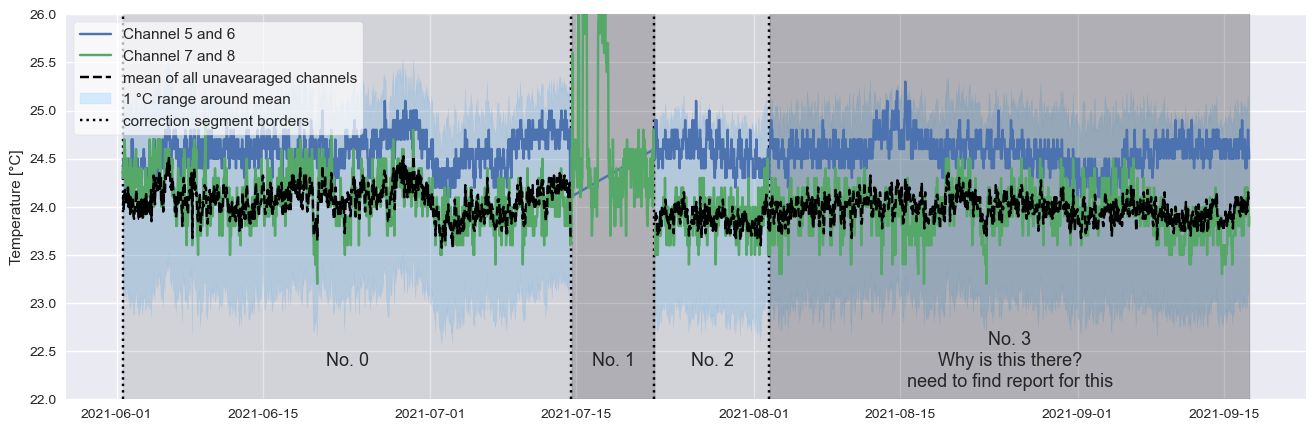

Cable length: 800 m


In [30]:
# compare avearged values to unavearaged ones - plot
# Erste axis mit tlogger weglassen?
# in alle Axen min max von allen channeln als hintergund plotten zur orientierung?
# eigentlich brauche ich für meine thesis nur die letzte axis würde ich sagen

cable_length=800 #watertank_len=[25,1689,1723,3389]
fig,axs=plt.subplots(1,1,figsize=(16,5))
data=data_all_processed_constshifted_averagefirst

# other axes
ymin=22; ymax=26
axs.plot(data["5and6"][cable_length].index,data["5and6"][cable_length].values,label="Channel 5 and 6")
axs.plot(data["7and8"][cable_length].index,data["7and8"][cable_length].values,label="Channel 7 and 8")
    
# mean off all channels - not aveargaed
summe=0
# to avoid datagaps when a nan occurs; I think I need calculate this date wise.
for chan in ["5","6","7","8"]:
    summe += resampled_data[chan][cable_length]
mean=summe/4 #nan values should cause nan in mean too
axs.plot(mean,label=f"mean of all unavearaged channels",color="black", linestyle="--")
axs.fill_between(mean.index,mean.values-1, mean.values+1,
                 #facecolor="blue", # The fill color
                 color='#7fc7ff',       # The outline color
                 alpha=0.3, label = "1 °C range around mean")          # Transparency of the fill

axs.vlines(dates,ymin,ymax,colors="black",linestyle=":", label="correction segment borders")    

axs.set_ylim(ymin,ymax)
axs.legend()
axs.set_ylabel("Temperature [°C]")
color_cable_pos_calb_seg(calibration_segments[0],0.1, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 0", label=True)
color_cable_pos_calb_seg(calibration_segments[1],0.25, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 1", label=True)
color_cable_pos_calb_seg(calibration_segments[2],0.1, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 2", label=True)
color_cable_pos_calb_seg(calibration_segments[3],0.25, ymax=ymax, ymin=ymin,axs=axs,
                label_name="No. 3\nWhy is this there?\nneed to find report for this", label=True)
legend = axs.legend(fontsize=11, title_fontsize=12,frameon=True,loc="upper left")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7) #not supported with eps

# Save additional information so I can read them in my tex file
save_values_in_file(4,"cable_length_plot_final_data_avearage_ch58_one_length",cable_length,r"..\Masterthesis_tex\values_for_read_in_tex.txt")

if plot_save:
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\final_data_avearage_ch58_one_length.pdf", format="pdf",bbox_inches="tight")
plt.show()
print(f"Cable length: {cable_length} m")

## Extract Shaft
Old Desctiption, now I use my constshift data *Extract the shaft length from the avearaged data and save it. I will only save one avearaging method. I am not sure which one is better. I think they are both very similar. Ich nehme einfach mal shiftfirst*

I will save only avearage of 7 and 8 because there is not Noise in the middle. Although the avearage of 5 and 6 has slightly better statistics at the watertank positions

# I did not check the const shift data statistc to watertank


In [31]:
data_to_extract_from=data_all_processed_constshifted_averagefirst
# up down aufteilung noch nicht optimal, da Grenzen noch nicht perfekt sind
# deswegen sind die Differenzen noch relativ hoch

# aus farbigen Plot die Werte genommen
# stimmen nicht ganz, da differenz gerade Zahl sein müsste, deswegen etwas angepasst
# und damit die ersten Werte nicht so hoch sind auch angepasst
####################
#vielleicht ist tiefe Temperatur am Anfang auch durch umknicken vom Kabel?
begin_borehole_0 = 506
end_borehole_0   = 1207
begin_borehole_1 = 2207
end_borehole_1   = 2905
#- due to deleting some columns during processing
borehole_0_columnnames=data_to_extract_from["7and8"].columns[begin_borehole_0-6:end_borehole_0-5]
Schacht_7and8_0 = data_to_extract_from["7and8"][borehole_0_columnnames]
borehole_1_columnnames=data_to_extract_from["7and8"].columns[begin_borehole_1-8:end_borehole_1-7]
Schacht_7and8_1 = data_to_extract_from["7and8"][borehole_1_columnnames]
#extract both borehole positions
# zum speichern nur den 0er nehmen, da die Statistic an den Wassertanks besser ist (da bei den andern das Signal länger unterwegs ist und noch Einfluss Spleißen?) 

new_column_names=np.arange(0, end_borehole_0 - begin_borehole_0 + 1, 1)
Schacht_7and8_0.columns=new_column_names
# down and up are not really correct because its the avearaged data
Schacht_7and8_0_down_columns = Schacht_7and8_0.columns[0:int(len(Schacht_7and8_0.columns)/2)]
Schacht_7and8_0_down = Schacht_7and8_0[Schacht_7and8_0_down_columns]
Schacht_7and8_0_down.columns.names = ["Depth [m]"]

Schacht_7and8_0_up_columns = Schacht_7and8_0.columns[int(len(Schacht_7and8_0.columns)/2):]
Schacht_7and8_0_up = Schacht_7and8_0[Schacht_7and8_0_up_columns]
Schacht_7and8_0_up.columns = Schacht_7and8_0_down.columns[::-1] # rename the columns so they fit to borehole depth
Schacht_7and8_0_up = Schacht_7and8_0_up[Schacht_7and8_0_up.columns[::-1]]

# remove unecessary digits
Schacht_7and8_0_up = round(Schacht_7and8_0_up, 1)
Schacht_7and8_0_down = round(Schacht_7and8_0_down, 1)


In [32]:
# diff = Schacht_7and8_0_up - Schacht_7and8_0_down
# plt.plot(diff.mean(axis=0))

In [33]:
# Save final Temperature Shaft

save_to=r"..\Alsdorf\Daten\my_database\shaft_final_temperature\egrt_cable\pickle"
filename=f"\\Schacht_7and8_down"
write_pickle(save_to+filename,Schacht_7and8_0_down)
filename=f"\\Schacht_7and8_up"
write_pickle(save_to+filename,Schacht_7and8_0_up)

save_to=r"..\Alsdorf\Daten\my_database\shaft_final_temperature\egrt_cable\csv"
filename=f"\\Schacht_7and8_down"
Schacht_7and8_0_down.to_csv(save_to+filename+".csv")
filename=f"\\Schacht_7and8_up"
Schacht_7and8_0_up.to_csv(save_to+filename+".csv")

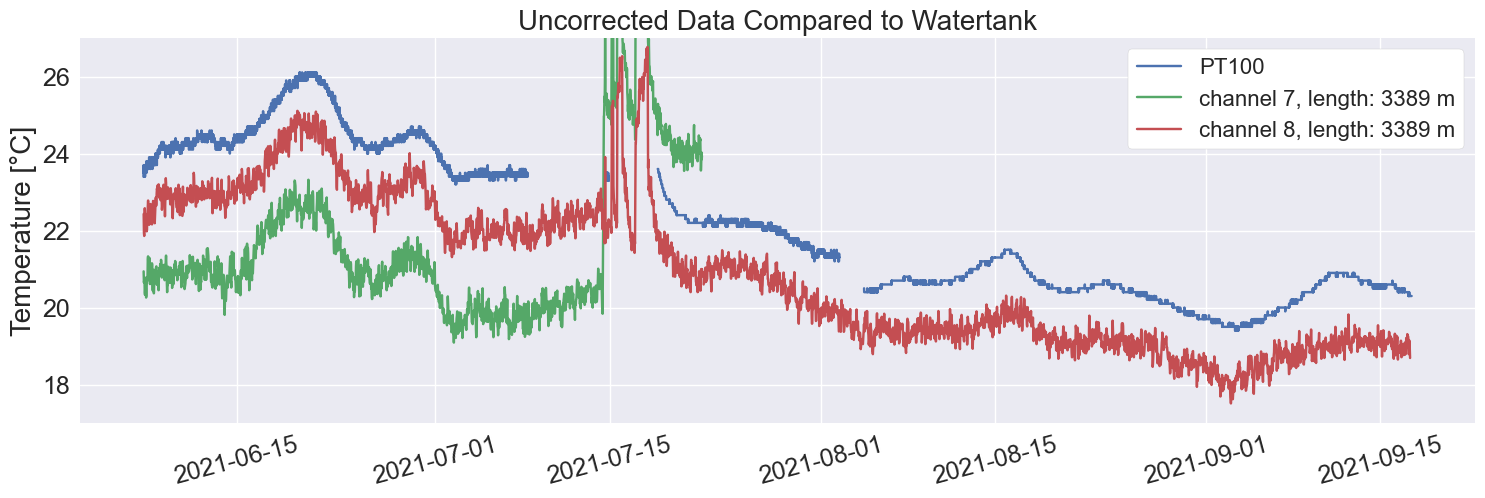

In [34]:
# Compare watertank to uncorrected channels
#ACHTUNG!! bei processing lösche ich einige Werte, sodass index sich ändert!!!
# --> data_all sollte nicht verwendet werden zu bestimmung der Wassrttank position
watertank_EGRT = 3389 #1689 # ich muss mir angucken welche Länge bei Mittelung mit dieser gemittelt wird um zu sehen, ob diese Länge
# evntl. schon sußerhalb vom Wassertank ist

#start = 
#end = 15800

fig, axs = plt.subplots(figsize=(18,5))
axs.plot(df_Tlogger_PT100.index[:], df_Tlogger_PT100["Channel1-Watertank_PT100"][:], label="PT100")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["7","8"]: #: ["5","6","7","8"]: 
    inde=data_all_processed[c][str(df_Tlogger_PT100.index[:].min()) : str(df_Tlogger_PT100.index[:].max())][watertank_EGRT].index
    val=data_all_processed[c][str(df_Tlogger_PT100.index[:].min()) : str(df_Tlogger_PT100.index[:].max())][watertank_EGRT].values
    axs.plot(inde,val, label=f"channel {c}, length: {data_all_processed[c][watertank_EGRT].name} m")

    # inde=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][1707-watertank_EGRT].index
    # val=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][1707-watertank_EGRT].values
    # plt.plot(inde,val, label=f"channel {c} length {1707-watertank_EGRT}")

font=20
axs.set_ylabel("Temperature [°C]",fontsize=font)
#axs.set_xlabel("Date",fontsize=16)
axs.set_title("Uncorrected Data Compared to Watertank",fontsize=font)
axs.tick_params(axis='x', which='major', labelsize=font-2, labelrotation=15)
axs.tick_params(axis='y', which='major', labelsize=font-2, labelrotation=0)
legend = axs.legend(fontsize=font-4, frameon=True)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor("white")
axs.set_ylim(17,27)

#plt.savefig("pictures/raw_data_compared_to_watertank.png",dpi=720,bbox_inches="tight")

plt.show()

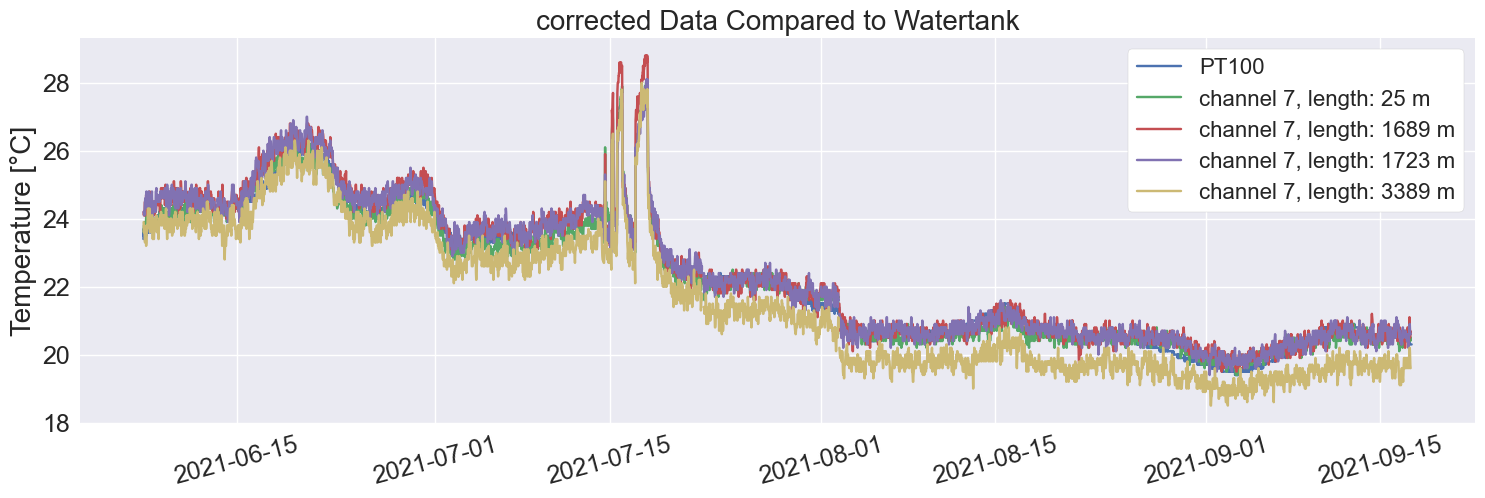

In [35]:
# Compare watertank to uncorrected channels
#ACHTUNG!! bei processing lösche ich einige Werte, sodass index sich ändert!!!
# --> data_all sollte nicht verwendet werden zu bestimmung der Wassrttank position
# [25,1689,1723,3389]
watertank_EGRT = [25,1689,1723,3389] #1689 # ich muss mir angucken welche Länge bei Mittelung mit dieser gemittelt wird um zu sehen, ob diese Länge
# evntl. schon sußerhalb vom Wassertank ist
channel="7"
data=data_all_processed_constshifted #data_all_processed
#start = 
#end = 15800

fig, axs = plt.subplots(figsize=(18,5))
axs.plot(df_Tlogger_PT100.index[:], df_Tlogger_PT100["Channel1-Watertank_PT100"][:], label="PT100")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for length in watertank_EGRT: #["7","8"]: #: 
    inde=data[channel][str(df_Tlogger_PT100.index[:].min()) : str(df_Tlogger_PT100.index[:].max())][length].index
    val=data[channel][str(df_Tlogger_PT100.index[:].min()) : str(df_Tlogger_PT100.index[:].max())][length].values
    l=data[channel][length].name
    axs.plot(inde,val, label=f"channel {channel}, length: {l} m")

    # inde=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][1707-watertank_EGRT].index
    # val=data_2021[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][1707-watertank_EGRT].values
    # plt.plot(inde,val, label=f"channel {c} length {1707-watertank_EGRT}")

font=20
axs.set_ylabel("Temperature [°C]",fontsize=font)
#axs.set_xlabel("Date",fontsize=16)
axs.set_title("corrected Data Compared to Watertank",fontsize=font)
axs.tick_params(axis='x', which='major', labelsize=font-2, labelrotation=15)
axs.tick_params(axis='y', which='major', labelsize=font-2, labelrotation=0)
legend = axs.legend(fontsize=font-4, frameon=True)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor("white")

#plt.savefig("pictures/raw_data_compared_to_watertank.png",dpi=720,bbox_inches="tight")

plt.show()

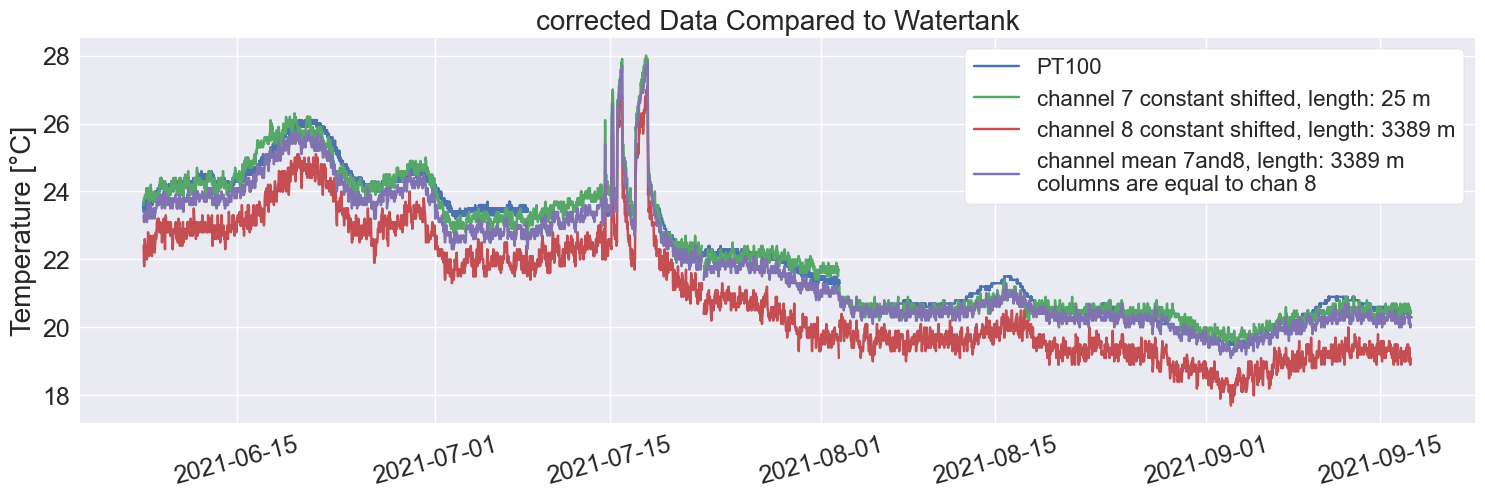

In [36]:
# Compare the data which will be avearaged
#ACHTUNG!! bei processing lösche ich einige Werte, sodass index sich ändert!!!
# --> data_all sollte nicht verwendet werden zu bestimmung der Wassrttank position
# [25,1689,1723,3389]
watertank_EGRT = [25,1689,1723,3389] #1689 # ich muss mir angucken welche Länge bei Mittelung mit dieser gemittelt wird um zu sehen, ob diese Länge
# evntl. schon sußerhalb vom Wassertank ist
data=data_all_processed_constshifted #data_all_processed
#start = 
#end = 15800

fig, axs = plt.subplots(figsize=(18,5))
axs.plot(df_Tlogger_PT100.index[:], df_Tlogger_PT100["Channel1-Watertank_PT100"][:], label="PT100")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for length in [25]:#watertank_EGRT: 
    channel="7"
    inde=data[channel][str(df_Tlogger_PT100.index[:].min()) : str(df_Tlogger_PT100.index[:].max())][length].index
    val=data[channel][str(df_Tlogger_PT100.index[:].min()) : str(df_Tlogger_PT100.index[:].max())][length].values
    l=data[channel][length].name
    axs.plot(inde,val, label=f"channel {channel} constant shifted, length: {l} m")

for length in [3389]:#watertank_EGRT: 
    channel="8"
    inde=data[channel][str(df_Tlogger_PT100.index.min()) : str(df_Tlogger_PT100.index.max())][length].index
    val=data[channel][str(df_Tlogger_PT100.index.min()) : str(df_Tlogger_PT100.index.max())][length].values
    l=data[channel][length].name
    plt.plot(inde,val, label=f"channel {channel} constant shifted, length: {l} m")

for length in [3389]:#watertank_EGRT: 
    channel="7and8"
    data=data_all_processed_constshifted_averagefirst #mean_constshift
    inde=data[channel][str(df_Tlogger_PT100.index.min()) : str(df_Tlogger_PT100.index.max())][length].index
    val=data[channel][str(df_Tlogger_PT100.index.min()) : str(df_Tlogger_PT100.index.max())][length].values
    l=data[channel][length].name
    plt.plot(inde,val, label=f"channel mean {channel}, length: {l} m\ncolumns are equal to chan 8")


font=20
axs.set_ylabel("Temperature [°C]",fontsize=font)
#axs.set_xlabel("Date",fontsize=16)
axs.set_title("corrected Data Compared to Watertank",fontsize=font)
axs.tick_params(axis='x', which='major', labelsize=font-2, labelrotation=15)
axs.tick_params(axis='y', which='major', labelsize=font-2, labelrotation=0)
legend = axs.legend(fontsize=font-4, frameon=True)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor("white")

#plt.savefig("pictures/raw_data_compared_to_watertank.png",dpi=720,bbox_inches="tight")

plt.show()

In [37]:
# data=data_all_processed_constshifted
# inde=data[channel][str(df_Tlogger_PT100.index.min()) : str(df_Tlogger_PT100.index.max())][length].index
# val=data[channel][str(df_Tlogger_PT100.index.min()) : str(df_Tlogger_PT100.index.max())][length].values
# l=data[channel][length].name
# plt.plot(inde,val, label=f"channel {channel}, length: {l} m")

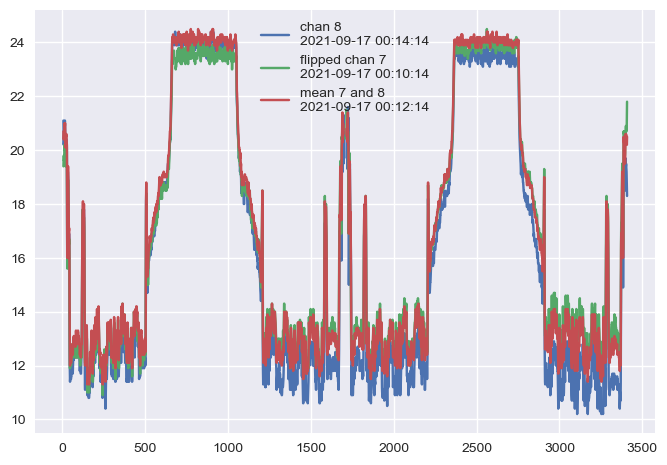

In [38]:
date = data_all_processed_constshifted["8"].iloc[-20].name
plt.plot(data_all_processed_constshifted["8"].iloc[-20], label=f"chan 8\n{date}") 
#plt.plot(data_all_processed_constshifted["7"].iloc[-20],label="chan 7") 

#sollte ich den Trend korrigieren? --> Trend ist stärker als bei channel 7 deswegen gleicht das avearaging es nicht richtig aus
# bei iloc[1000], bei iloc[-10] haben beide einen ähnlichen Trend
flipped = deepcopy(data_all_processed_constshifted["7"].iloc[-20])
flipped.index = flipped.index[::-1]
date= flipped.name
plt.plot(flipped,label=f"flipped chan 7\n{date}")

date=data_all_processed_constshifted_averagefirst["7and8"].iloc[-20].name
plt.plot(data_all_processed_constshifted_averagefirst["7and8"].iloc[-20],label=f"mean 7 and 8\n{date}")


plt.legend()
plt.show()

In [39]:
# Test is avearaging function works as expected
# check if the watertank positions of the two channels are avearaged
test_data1 = deepcopy(data_all_processed_constshifted["7"][::20])
test_data2 = deepcopy(data_all_processed_constshifted["8"][::20])
test_data3 = deepcopy(data_all_processed_constshifted["5"][::20])
test_data4 = deepcopy(data_all_processed_constshifted["6"][::20])

for column in test_data1.columns:
    test_data1[column] = 10
for column in test_data2.columns:
    test_data2[column] = 30
for column in test_data3.columns:
    test_data3[column] = 10
for column in test_data4.columns:
    test_data4[column] = 30

# watertank_positions
# Each pair here should be avearaged, the result of each pair is 2
watertank_EGRT = [25,1689,1723,3389] #############################################nicht hier neu definieren
test_data1[watertank_EGRT[0]] = 1
test_data2[watertank_EGRT[3]] = 3

test_data1[watertank_EGRT[1]] = -1
test_data2[watertank_EGRT[2]] = 5

test_data1[watertank_EGRT[2]] = -2
test_data2[watertank_EGRT[1]] = 6

test_data1[watertank_EGRT[3]] = -3
test_data2[watertank_EGRT[0]] = 7

# Other channels
test_data3[watertank_EGRT[0]] = 1
test_data4[watertank_EGRT[1]] = 3

test_data3[watertank_EGRT[1]] = -1
test_data4[watertank_EGRT[0]] = 5

# expected behavior: at watertank positions the avearage should be 2, everywhere else 20
# if a watertankposition is not avearaged with its partner the result will be different
test_result_12 = avearge_two_channels(test_data1, test_data2)
test_result_34 = avearge_two_channels(test_data3, test_data4)

# Check Test results
error=False
for watank_len in watertank_EGRT:
    if test_result_12[watank_len].mean() != 2:
        error=True
        print(f"Test failed at {watank_len}, something is wrong in avearaging the data.")
if error ==False:
    print("test channel 7 and 8 passed")
    del test_data1
    del test_data2
    del test_result_12
else:
    print("test channel 7 and 8 failed")
print()
# other channels
error=False
for watank_len in watertank_EGRT[:2]:
    if test_result_34[watank_len].mean() != 2:
        error=True
        print(f"Test failed at {watank_len}, something is wrong in avearaging the data.")
if error ==False:
    print("test channel 5 and 6 passed")
    del test_data3
    del test_data4
    del test_result_34
else:
    print("test channel 5 and 6 failed")


test channel 7 and 8 passed

test channel 5 and 6 passed


# Frequency analysis

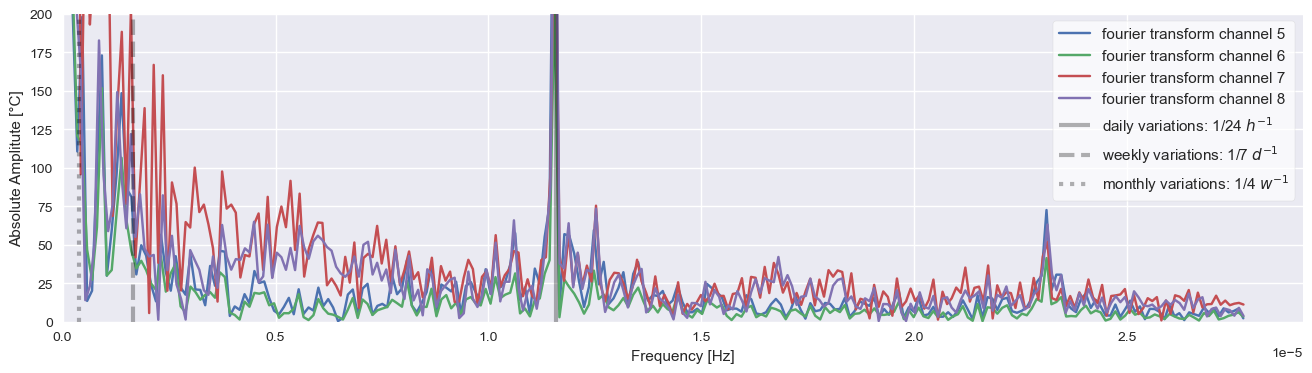

In [40]:
data_resample={}
sampling_time={}
yf={}
xf={}
depth=250
cable_length=28 #only for data_all_processed_constshifted
data_type="data_all" # I create a plot with this data type for my thesis
#watertank_len: [24,1689,1723,3389]

for channel in ["5","6","7","8"]:
    #data=data_all_processed_constshifted_averagefirst[channel][cable_length]
    data=data_all_processed[channel][cable_length]
    if data_type=="data_all":
        data=data_all[channel][cable_length]

    # Resample data
    data_resample[channel], sampling_time[channel] = resample_data_func(data) #resample_hours=5
    if channel in ["5","6","5and6"]:
        # Remove date gaps, meaning delete points so neighbaring points are atleast similar in time of day
        bool_no_data=data_resample[channel].notna() == False
        bool_data=data_resample[channel].notna()

        # data gaps fits already good
        data_resample[channel]=data_resample[channel][bool_data]

        # Check if everything is as expected with this code
        # diff=data_resample[bool_data].index[1:] - data_resample[bool_data].index[:-1]
        # diff.sort_values() #diff should be all around 5 h, ignoring full days
        # # diff.get_loc(diff.sort_values()[-1])

    # Fourier Transform
    yf[channel], xf[channel] = fourier_transform(data_resample[channel], sampling_time[channel])

# Plor fourier Spectrum
vlines=[] #[1/(60*60*12)]
vlines_labels=[] #["half a day varaitions: 1/12 $h^{-1}$"]

plot_frequency_spectrum(xf, yf, vlines, vlines_labels, ylim=[0,200])

if cable_length == 24 and data_type=="data_all":
    if plot_save:
        plt.savefig(r"..\Masterthesis_tex\figs\chap4\chan58_cable_length_24_fourier.pdf", format="pdf",bbox_inches="tight")
        plt.savefig("pictures\chan58_cable_length_24_fourier.png")

if cable_length == 28 and data_type=="data_all":
    if plot_save:
        plt.savefig(r"..\Masterthesis_tex\appendix\chan58_cable_length_28_fourier.pdf", format="pdf",bbox_inches="tight")
        plt.savefig("pictures\chan58_cable_length_28_fourier.png")
plt.show()

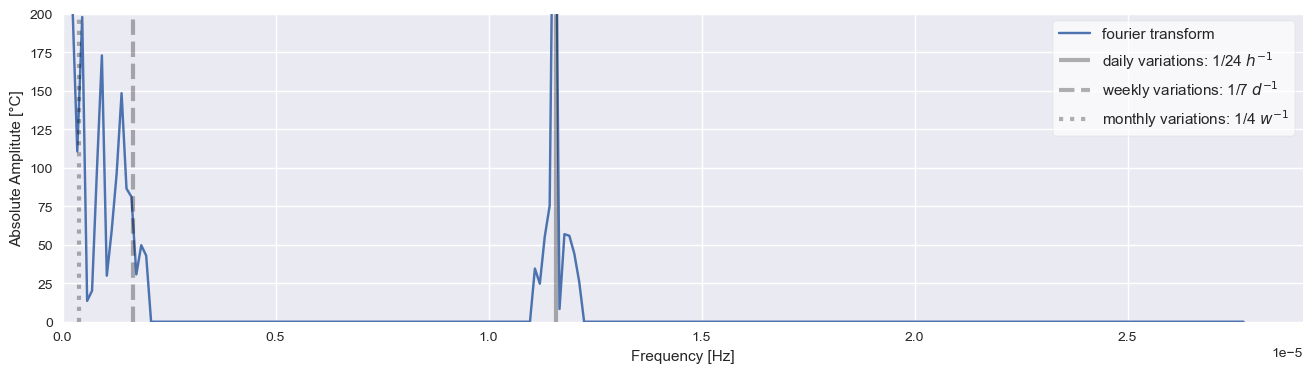

In [41]:
channel="5"
#Signal Filtering
f_signal = yf[channel]
W = xf[channel]
# 1 day fluctutation:
T_day=24*60*60
f_day=1/T_day

# remove frequencies from signal
cut_f_signal = f_signal.copy()
cut_f_signal[(W>1.05*f_day)] = 0
cut_f_signal[((W<0.95*f_day) & (W>2e-6))] = 0
#cut_f_signal[(W>0.8e-6)] = 0

plot_frequency_spectrum(W, cut_f_signal, vlines, vlines_labels, ylim=[0,200])
plt.show()

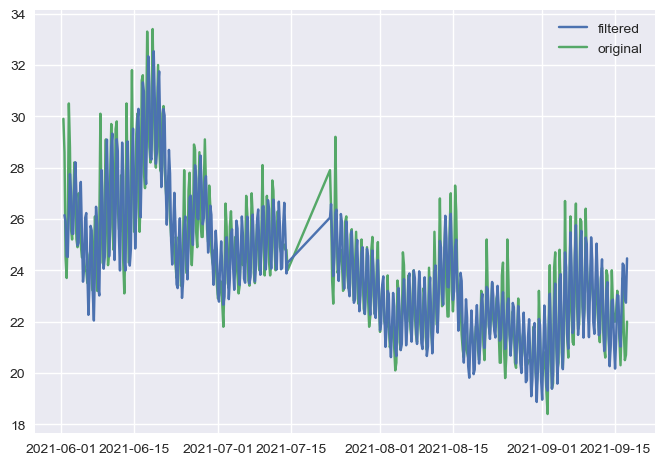

In [42]:
# Retransfrom
cut_signal = irfft(cut_f_signal)

# Plot filtered signal
dates=5000000000 #only show last x days
plt.plot(data_resample[channel].index[-dates:][1:],cut_signal[-dates:],label="filtered",zorder=10) #depending on channel add [1:]
plt.plot(data_resample[channel].index[-dates:],data_resample[channel].values[-dates:],label="original",zorder=1)
plt.legend()
plt.show()
